In [1]:
# !pip install deeplake


# import deeplake

# ds = deeplake.load(
# 'hub://activeloop/speech-commands-train')

# ds.visualize()


In [1]:
import torchaudio
import matplotlib.pyplot as plt
import librosa.display

# load dataset
dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./", download=True)

# visualization function
def visualize_audio(index):
    waveform, sample_rate, label, *_ = dataset[index]
    plt.figure()
    librosa.display.waveshow(waveform.numpy()[0], sr=sample_rate)
    plt.title(f"Label: {label}")
    plt.show()


100%|██████████| 2.26G/2.26G [00:24<00:00, 101MB/s]


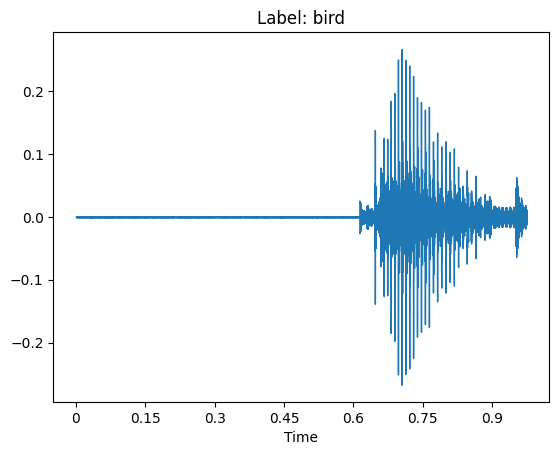

In [2]:
visualize_audio(5000)

In [3]:
dataset[1]


(tensor([[-0.0003, -0.0002, -0.0005,  ...,  0.0005,  0.0007,  0.0010]]),
 16000,
 'backward',
 '017c4098',
 0)

In [4]:
from IPython.display import Audio

waveform, sample_rate, label, speaker_id, utterance_number = dataset[5000]

# Play the audio
Audio(waveform.numpy(), rate=sample_rate)

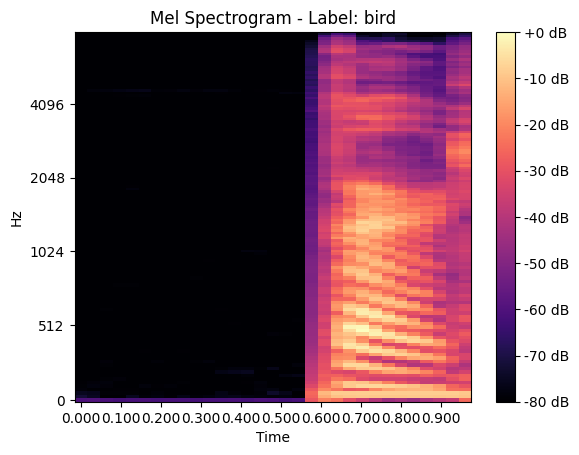

In [5]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Function to convert waveform to Mel spectrogram
def waveform_to_melspectrogram(waveform, sample_rate):
    S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

# Visualize Mel spectrogram
def visualize_melspectrogram(index):
    waveform, sample_rate, label, *_ = dataset[index]
    S_DB = waveform_to_melspectrogram(waveform.numpy()[0], sample_rate)
    plt.figure()
    librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - Label: {label}")
    plt.show()

visualize_melspectrogram(5000)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch
from torch.utils.data import Dataset
import torchaudio
import librosa
import torchaudio.transforms as transforms

# Load your original dataset
original_dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./", download=True)

# Extract all labels from the original dataset
labels = [label for _, _, label, _, _ in original_dataset]
# Create a mapping of labels to indices
label_to_index = {label: index for index, label in enumerate(sorted(set(labels)))}
num_classes = len(label_to_index)

In [7]:
class MelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, target_length=128):
        self.dataset = dataset
        self.mel_spectrogram = transforms.MelSpectrogram()
        self.target_length = target_length  # Target length for all spectrograms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, _, label, _, _ = self.dataset[idx]
        mel_spec = self.mel_spectrogram(waveform)

        # Check and modify the size of mel_spec to match target_length
        current_length = mel_spec.shape[2]
        if current_length < self.target_length:
            padding_amount = self.target_length - current_length
            mel_spec = torch.nn.functional.pad(mel_spec, (0, padding_amount))
        elif current_length > self.target_length:
            mel_spec = mel_spec[:, :, :self.target_length]

        label_index = label_to_index[label]
        return mel_spec, label_index

In [9]:
# Convert the original dataset to Mel spectrograms
mel_dataset = MelSpectrogramDataset(original_dataset)


# Split the dataset into training and testing sets
train_size = int(0.8 * len(mel_dataset))  # 80% of the dataset for training
test_size = len(mel_dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(mel_dataset, [train_size, test_size])  # Random split

num_classes = len(set(labels))

# # Load a pre-trained ResNet18 model
# model = models.resnet18(pretrained=True)  # Pretrained ResNet18 model
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# num_ftrs = model.fc.in_features  # Number of features in last layer
# model.fc = nn.Linear(num_ftrs, num_classes)  # Replace last layer with new layer for our number of classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent optimizer

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # DataLoader for training data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # DataLoader for testing data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [14]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 500) # Adjust the input size
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32) # Adjust the flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [16]:
num_epochs = 1
# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_loader):  # Iterate over each batch and keep track of the index with enumerate
        inputs, labels = data  # Get the input data and labels
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update weights

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}")

Epoch 1/1, Batch 47/2646
Epoch 1/1, Batch 48/2646
Epoch 1/1, Batch 49/2646
Epoch 1/1, Batch 50/2646
Epoch 1/1, Batch 51/2646
Epoch 1/1, Batch 52/2646
Epoch 1/1, Batch 53/2646
Epoch 1/1, Batch 54/2646
Epoch 1/1, Batch 55/2646
Epoch 1/1, Batch 56/2646
Epoch 1/1, Batch 57/2646
Epoch 1/1, Batch 58/2646
Epoch 1/1, Batch 59/2646
Epoch 1/1, Batch 60/2646
Epoch 1/1, Batch 61/2646
Epoch 1/1, Batch 62/2646
Epoch 1/1, Batch 63/2646
Epoch 1/1, Batch 64/2646
Epoch 1/1, Batch 65/2646
Epoch 1/1, Batch 66/2646
Epoch 1/1, Batch 67/2646
Epoch 1/1, Batch 68/2646
Epoch 1/1, Batch 69/2646
Epoch 1/1, Batch 70/2646
Epoch 1/1, Batch 71/2646
Epoch 1/1, Batch 72/2646
Epoch 1/1, Batch 73/2646
Epoch 1/1, Batch 74/2646
Epoch 1/1, Batch 75/2646
Epoch 1/1, Batch 76/2646
Epoch 1/1, Batch 77/2646
Epoch 1/1, Batch 78/2646
Epoch 1/1, Batch 79/2646
Epoch 1/1, Batch 80/2646
Epoch 1/1, Batch 81/2646
Epoch 1/1, Batch 82/2646
Epoch 1/1, Batch 83/2646
Epoch 1/1, Batch 84/2646
Epoch 1/1, Batch 85/2646
Epoch 1/1, Batch 86/2646


In [17]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0  # Count of correct predictions
total = 0  # Total number of predictions
with torch.no_grad():  # Disabling gradient calculation
    for data in test_loader:  # Iterate over test data
        inputs, labels = data  # Get the input data and labels
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        total += labels.size(0)  # Update total count
        correct += (predicted == labels).sum().item()  # Update correct count

In [18]:
# Print accuracy
print(f'Accuracy of the network on test images: {100 * correct // total}%')  # Calculate and print the accuracy

Accuracy of the network on test images: 2%


In [19]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Assuming you have a 'test_loader' DataLoader for your test dataset
epsilon = 0.1  # Example epsilon value
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

for data, target in test_loader:
    data.requires_grad = True

    # Forward pass
    output = model(data)
    loss = F.nll_loss(output, target)

    # Zero gradients, perform a backward pass, and update the weights.
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    # FGSM attack
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_output = model(perturbed_data)

    # Get the predicted class from the perturbed output
    _, predicted = torch.max(perturbed_output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy after FGSM attack: {accuracy}%')

Accuracy after FGSM attack: 1.0819238401209488%
